### SPATIAL FEATURES AND SEPARATE REGRESSIONS

In [1]:
# Modules.
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
# Import necessary libraries for modeling and CV.
from sklearn.model_selection import KFold, cross_val_score, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import BallTree
import xgboost as xgb
import statsmodels.api as sm
from tqdm import tqdm
import shap
import warnings
from esda.moran import Moran
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal as ps
from esda.moran import Moran
from spreg import GM_Error
warnings.filterwarnings("ignore")

In [2]:
# Paths.
weekly_path = "data/model/nyc_tract_summer_2025_weekly.csv"
# The following paths are now unnecessary if the data is already in weekly_path.
# acs_path = "data/acs/acs_socioeconomic_tract_2022.csv"
# nlcd_path = "data/raster/nlcd_calc_tracts.csv"
# addfeat_path = "data/additional_features/nyc_tracts_new_variables.csv"
tracts_path = "data/nyc_tracts_2020/nyc_tracts_2020.shp"
nyc_boundary_path = "data/nyc_city_boundary_with_water/nyc_city_boundary_with_water.shp"

# Load base dataframes.
panel = pd.read_csv(weekly_path)
# acs = pd.read_csv(acs_path)
# nlcd = pd.read_csv(nlcd_path)
# addfeat = pd.read_csv(addfeat_path)

In [3]:
panel.columns

Index(['GEOID', 'WEEK', 'TOTAL_CALLS_WEEK', 'QOL_CALLS_WEEK',
       'EXTREME_DAYS_WEEK', 'MEDIAN_TMAX_F', 'EXTREME_WEEK_1',
       'EXTREME_WEEK_2', 'TOTAL_POP', 'MEDIAN_INCOME', 'NO_VEHICLE_HH',
       'HH_TOTAL', 'POP_DENSITY', 'POVERTY_RATE', 'PCT_BACHELORS_PLUS',
       'PCT_RENTERS', 'PCT_LIMITED_ENGLISH', 'PCT_TREE_CANOPY',
       'PCT_IMPERVIOUS', 'MEAN_LANDCOVER', 'BD', 'AH', 'NDVI', 'WCR',
       'QOL_RATE_1K', 'QOL_RATE_10K', 'LOG_QOL_RATE_1K', 'LOG_QOL_RATE_10K'],
      dtype='object')

In [4]:
panel["GEOID"] = panel["GEOID"].astype(str)

# Dependent variable.
y_col = "QOL_RATE_1K"
panel = panel.dropna(subset=[y_col])

In [5]:
# Load and prepare tracts.
tracts = gpd.read_file(tracts_path)
tracts["geoid"] = tracts["geoid"].astype(str)
tracts = tracts.to_crs("EPSG:32118")
tracts["centroid"] = tracts.centroid
tracts["x"] = tracts.centroid.x
tracts["y"] = tracts.centroid.y

In [6]:
# Load street network.
G = ox.graph_from_place("New York City, New York, USA", network_type="walk")
G = ox.project_graph(G)

In [7]:
# Assign tract centroids to nearest network nodes.
tracts["nn"] = ox.nearest_nodes(G, tracts["x"], tracts["y"])

In [8]:
def euclidean_knn_three(tracts, poi, k=3, label="KNN_EUCLID"):
    """Calculates the Euclidean distance (straight-line) to the k=3 nearest POIs."""
    tract_xy = np.vstack([tracts["x"], tracts["y"]]).T
    poi_xy = np.vstack([poi["x"], poi["y"]]).T

    # Build the BallTree on the POI coordinates (fast).
    tree = BallTree(poi_xy, metric="euclidean")

    # Query the tree for the k=3 nearest neighbors and their distances (fast).
    dists, _ = tree.query(tract_xy, k=k)

    results = {}
    for i in range(k):
        # Store individual distances (e.g., KNN_EUCLID_dist1).
        results[f"{label}_dist{i+1}"] = dists[:, i]

    # Calculate the mean distance for the final feature.
    results[f"{label}_dist_mean"] = np.nanmean(dists, axis=1)

    return pd.DataFrame(results)

In [9]:
# Helper function for POI density (Euclidean distance).
def poi_density(tracts, poi, radius=500, label="POI"):
    """Calculates the number of POIs within a given radius of each tract centroid."""
    tract_xy = np.vstack([tracts["x"], tracts["y"]]).T
    poi_xy = np.vstack([poi["x"], poi["y"]]).T

    tree = BallTree(poi_xy, metric="euclidean")
    # Query_radius counts POIs within the 'r' distance.
    counts = tree.query_radius(tract_xy, r=radius, count_only=True)

    return pd.DataFrame({f"{label}_DENSITY": counts})

In [10]:
# Subway KNN (EUCLIDEAN).
print("Calculating Subway KNN (Euclidean distance)...")
subways = ox.features_from_place(
    "New York City, New York, USA",
    tags={"railway": "station"}
).to_crs(G.graph["crs"])

subways = subways[subways.geometry.type == "Point"].copy()
subways["x"] = subways.geometry.x
subways["y"] = subways.geometry.y
# Replaced network calculation with fast Euclidean calculation.
sub_knn = euclidean_knn_three(tracts, subways, label="KNN_SUBWAY")

Calculating Subway KNN (Euclidean distance)...


In [11]:
# Parks KNN (EUCLIDEAN).
print("Calculating Parks KNN (Euclidean distance)...")
parks = ox.features_from_place( # Fixed function name
    "New York City, New York, USA",
    tags={"leisure": "park"}
).to_crs(G.graph["crs"])
parks = parks[parks.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
parks["centroid"] = parks.geometry.centroid
parks["x"] = parks["centroid"].x
parks["y"] = parks["centroid"].y
# Replaced network calculation with fast Euclidean calculation.
park_knn = euclidean_knn_three(tracts, parks, label="KNN_PARKS")

Calculating Parks KNN (Euclidean distance)...


In [12]:
# POI Density (EUCLIDEAN).
print("Calculating POI Density (Euclidean distance)...")
poi_tags = {
    "amenity": ["bar", "pub", "nightclub", "restaurant"],
    "shop": ["convenience", "supermarket"]
}
custom_pois = ox.features_from_place( # Fixed function name
    "New York City, New York, USA",
    tags=poi_tags
).to_crs(tracts.crs)
custom_pois = custom_pois[custom_pois.geometry.type == "Point"].copy()
custom_pois["x"] = custom_pois.geometry.x
custom_pois["y"] = custom_pois.geometry.y

# POI Density calculation (radius=500m).
poi_den = poi_density(tracts, custom_pois, radius=500, label="POI_500M")

Calculating POI Density (Euclidean distance)...


In [13]:
# Merge spatial features.
spatial_df = pd.concat(
    [sub_knn, park_knn, poi_den],
    axis=1
)

In [14]:
# Use the mean distance as the final feature for KNN.
tracts_spatial = pd.concat([tracts[["geoid"]].reset_index(drop=True), spatial_df], axis=1)
panel = panel.merge(tracts_spatial, left_on="GEOID", right_on="geoid", how="left")
panel.drop(columns=["geoid"], inplace=True)

In [15]:
# Model Configuration
# Define the new predictor categories.
env_variables = [
    "PCT_TREE_CANOPY", "PCT_IMPERVIOUS", "WCR", "NDVI"
]

acs_variables = [
    "PCT_BACHELORS_PLUS", "PCT_RENTERS", "PCT_LIMITED_ENGLISH", "MEDIAN_INCOME"
]

# Use the mean distance for KNN and the calculated density for POI Density.
urban_variables = [
    "KNN_SUBWAY_dist_mean",
    "POI_500M_DENSITY",
    #"KNN_PARKS_dist_mean", HIGHLY MULTICOLLINEAR WITH SUBWAY.
    "BD",
    "AH"
]

# Group all predictors for the XGBoost model later.
all_predictors = env_variables + acs_variables + urban_variables

predictor_sets = {
    "ENV": env_variables,
    "ENV+ACS": env_variables + acs_variables,
    "FULL": all_predictors
}

# Define the four heat regime subsets.
df_regimes = {
    "HEAT_W1": panel[panel["EXTREME_WEEK_1"] == 1].copy(),
    "HEAT_W2": panel[panel["EXTREME_WEEK_2"] == 1].copy(),
    "NORMAL_W1": panel[panel["EXTREME_WEEK_1"] == 0].copy(),
    "NORMAL_W2": panel[panel["EXTREME_WEEK_2"] == 0].copy()
}

In [16]:
# OLS Regression and Cross-Validation
def run_ols_cv(df, predictors, y_col):
    """Runs OLS regression and performs 10-fold cross-validation on R-squared."""
    # OLS model setup with constant.
    X = df[predictors].astype(float)
    X = sm.add_constant(X)
    y = df[y_col].astype(float)

    # Fit the OLS model for summary output.
    model = sm.OLS(y, X, missing='drop').fit()

    # Linear Regression model from sklearn for CV.
    lr = LinearRegression()

    # 10-fold Cross-Validation.
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(lr, X.dropna(), y[X.index], scoring="r2", cv=kf)

    return model, scores.mean(), scores.std()

ols_results = {}
best_r2 = -np.inf
best_model_data = None

In [17]:
# OLS model with 10-fold CV.
for subset_name, df_subset in df_regimes.items():
    print(f"\nType: {subset_name}")

    ols_results[subset_name] = {}

    for name, preds in predictor_sets.items():
        # Ensure only common, non-null data is used.
        valid_indices = df_subset[preds + [y_col]].dropna().index
        df_valid = df_subset.loc[valid_indices]

        if not df_valid.empty:
            m, r2_mean, r2_std = run_ols_cv(df_valid, preds, y_col)
            ols_results[subset_name][name] = (m, r2_mean, r2_std)

            print(f"  Predictor Set: {name}")
            print(f"    Adj. R-squared: {m.rsquared_adj:.4f}")
            print(f"    CV R-squared (Mean ± Std): {r2_mean:.4f} ± {r2_std:.4f}")

            # Track the model with the highest CV R-squared (best OLS regression).
            if r2_mean > best_r2:
                best_r2 = r2_mean
                best_model_data = {
                    "df": df_valid,
                    "predictors": preds,
                    "regime": subset_name,
                    "set_name": name
                }
        else:
            print(f"  Predictor Set: {name} - Insufficient data after dropping NaNs.")


Type: HEAT_W1
  Predictor Set: ENV
    Adj. R-squared: 0.0064
    CV R-squared (Mean ± Std): 0.0056 ± 0.0042
  Predictor Set: ENV+ACS
    Adj. R-squared: 0.0336
    CV R-squared (Mean ± Std): 0.0319 ± 0.0060
  Predictor Set: FULL
    Adj. R-squared: 0.0634
    CV R-squared (Mean ± Std): 0.0613 ± 0.0109

Type: HEAT_W2
  Predictor Set: ENV
    Adj. R-squared: 0.0064
    CV R-squared (Mean ± Std): 0.0057 ± 0.0070
  Predictor Set: ENV+ACS
    Adj. R-squared: 0.0366
    CV R-squared (Mean ± Std): 0.0327 ± 0.0154
  Predictor Set: FULL
    Adj. R-squared: 0.0688
    CV R-squared (Mean ± Std): 0.0640 ± 0.0164

Type: NORMAL_W1
  Predictor Set: ENV
    Adj. R-squared: 0.0062
    CV R-squared (Mean ± Std): 0.0053 ± 0.0060
  Predictor Set: ENV+ACS
    Adj. R-squared: 0.0215
    CV R-squared (Mean ± Std): 0.0203 ± 0.0066
  Predictor Set: FULL
    Adj. R-squared: 0.0380
    CV R-squared (Mean ± Std): 0.0363 ± 0.0101

Type: NORMAL_W2
  Predictor Set: ENV
    Adj. R-squared: 0.0064
    CV R-squared (

In [18]:
# VIF Calculation Function.
def calculate_vif(df):
    """Calculates Variance Inflation Factor for each feature."""
    X = sm.add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    # Note: X.values must be used for the calculation.
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data[vif_data.Feature != 'const']

# Extract best model data for diagnostics.
predictors_to_test = best_model_data['predictors']
# Ensure data is clean (only non-null rows used for the best model).
df_vif = best_model_data['df'][predictors_to_test].astype(float).dropna()


# VIF Results
vif_results = calculate_vif(df_vif)
print("\n--- VIF Results ---")
print(vif_results.sort_values(by='VIF', ascending=False).to_markdown(index=False))


--- VIF Results ---
| Feature              |     VIF |
|:---------------------|--------:|
| BD                   | 3.00682 |
| PCT_TREE_CANOPY      | 2.91007 |
| NDVI                 | 2.41774 |
| AH                   | 2.14534 |
| PCT_BACHELORS_PLUS   | 2.089   |
| POI_500M_DENSITY     | 2.02503 |
| PCT_IMPERVIOUS       | 1.72677 |
| PCT_RENTERS          | 1.66718 |
| KNN_SUBWAY_dist_mean | 1.28633 |
| PCT_LIMITED_ENGLISH  | 1.23008 |
| WCR                  | 1.1402  |
| MEDIAN_INCOME        | 1.02216 |


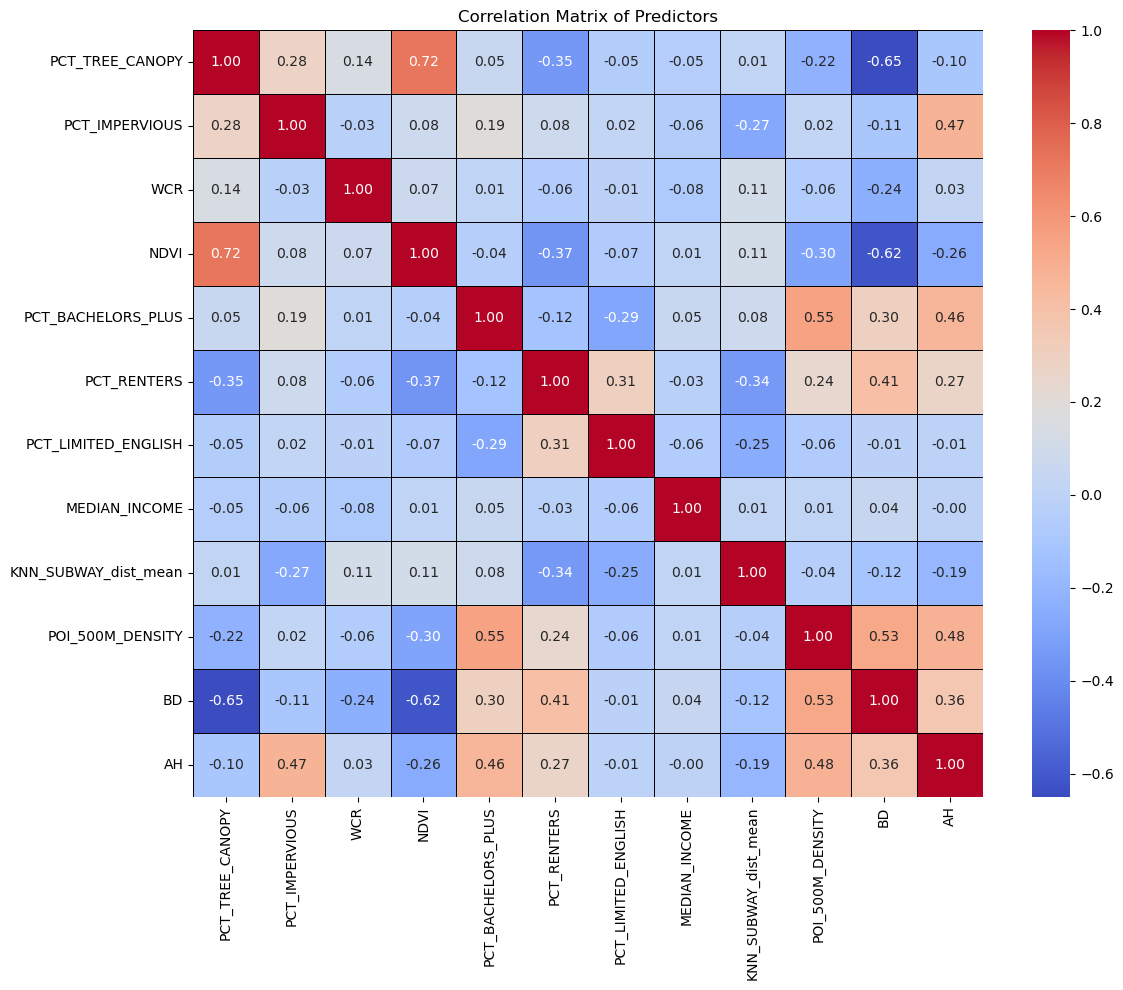

In [19]:
# Correlation Matrix Plot
plt.figure(figsize=(12, 10))
corr_matrix = df_vif.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)
plt.title('Correlation Matrix of Predictors')
plt.tight_layout()
#plt.savefig('correlation_matrix.png')


Best OLS Model for ML: HEAT_W2 with FULL Predictors (CV R-squared: 0.0640)

Training XGBoost Regressor...
XGBoost CV R-squared (Mean ± Std): 0.1104 ± 0.0350.

Calculating SHAP values...

SHAP Summary Plot (Bar - Mean Absolute Impact) 


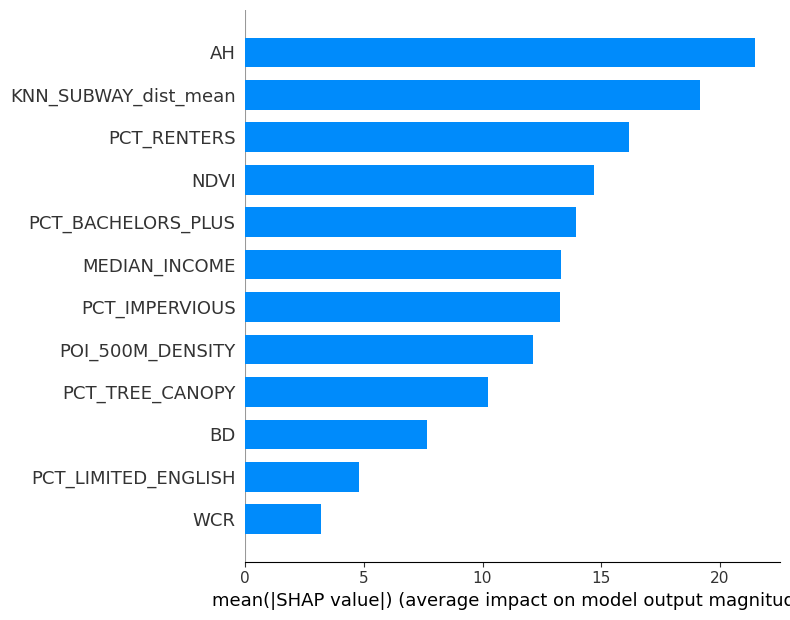


SHAP Summary Plot (Dots - Feature Importance and Direction) 


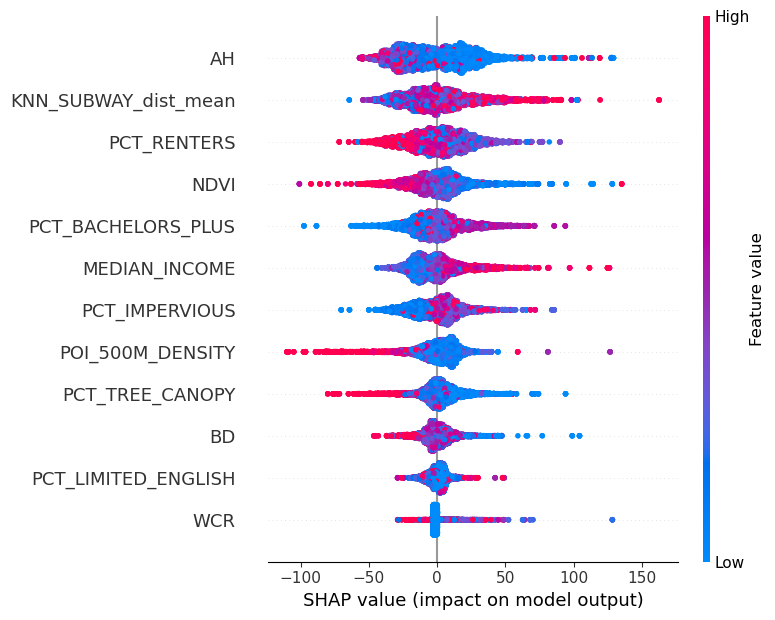

In [20]:
# XGBoost and SHAP Implementation
if best_model_data:
    print(f"\nBest OLS Model for ML: {best_model_data['regime']} with {best_model_data['set_name']} Predictors (CV R-squared: {best_r2:.4f})")

    X_best = best_model_data['df'][best_model_data['predictors']].astype(float)
    y_best = best_model_data['df'][y_col].astype(float)

    # 1. XGBoost Model Training.
    print("\nTraining XGBoost Regressor...")
    # Using a typical setup for a tabular regression problem.
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )

    # GroupKFold is ideal here to prevent leakage of tract-specific effects across folds.
    # We use the GEOID as the group key.
    groups = best_model_data['df']['GEOID']
    gkf = GroupKFold(n_splits=10)

    # Simple cross-validation score for the XGBoost model.
    xgb_scores = cross_val_score(xgb_reg, X_best, y_best, groups=groups, scoring='r2', cv=gkf)
    print(f"XGBoost CV R-squared (Mean ± Std): {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}.")

    # Fit the final model on the entire best dataset.
    xgb_reg.fit(X_best, y_best)

    # 2. SHAP (SHapley Additive exPlanations) Implementation.
    print("\nCalculating SHAP values...")
    # TreeExplainer is efficient for tree-based models like XGBoost.
    explainer = shap.TreeExplainer(xgb_reg)
    shap_values = explainer.shap_values(X_best)
    
    # Display the summary plots.
    print("\nSHAP Summary Plot (Bar - Mean Absolute Impact) ")
    shap.summary_plot(shap_values, X_best, plot_type="bar") # Uncomment to render plot in environment.
    
    print("\nSHAP Summary Plot (Dots - Feature Importance and Direction) ")
    shap.summary_plot(shap_values, X_best) # Uncomment to render plot in environment.
    
else:
    print("\nError: Could not find a suitable dataset to train the model.")

In [26]:
# 1. Calculate the Mean Absolute SHAP Value (Global Importance)
# This measures the average magnitude of impact for each feature across all predictions.
feature_impact = np.abs(shap_values).mean(axis=0)

# 2. Create and Display a Sorted DataFrame
# This provides the detailed, quantifiable statistics you were looking for.
shap_df = pd.DataFrame({
    'Feature': X_best.columns,
    'Mean_Absolute_SHAP': feature_impact
})

# Sort the features by their impact, descending
shap_df = shap_df.sort_values(by='Mean_Absolute_SHAP', ascending=False)

print("\nDetailed Feature Importance (Mean Absolute SHAP):")
# Display the top 10 features for a concise view
print(shap_df.head(10).to_markdown(index=False, floatfmt=".4f")) 

# Optional: You can save the full table to a file if needed
# shap_df.to_csv('xgb_feature_importance_shap.csv', index=False)


Detailed Feature Importance (Mean Absolute SHAP):
| Feature              |   Mean_Absolute_SHAP |
|:---------------------|---------------------:|
| AH                   |              21.4709 |
| KNN_SUBWAY_dist_mean |              19.1901 |
| PCT_RENTERS          |              16.1923 |
| NDVI                 |              14.6820 |
| PCT_BACHELORS_PLUS   |              13.9444 |
| MEDIAN_INCOME        |              13.3138 |
| PCT_IMPERVIOUS       |              13.2530 |
| POI_500M_DENSITY     |              12.1294 |
| PCT_TREE_CANOPY      |              10.2458 |
| BD                   |               7.6394 |


In [25]:
# The base value (expected value) is an attribute of the explainer
base_value = explainer.expected_value
sample_index = 4 # Example: looking at the 5th observation

print(f"\nSHAP Base Value (Expected Prediction): {base_value:.4f}")
print(f"Features and their SHAP contributions for sample {sample_index}:")

# Get SHAP contributions for the sample
sample_shap = pd.Series(shap_values[sample_index], index=X_best.columns)
print(sample_shap.sort_values(ascending=False))

# Reconstruct the prediction for verification
reconstructed_prediction = base_value + sample_shap.sum()
actual_prediction = xgb_reg.predict(X_best.iloc[[sample_index]])[0]

print(f"\nReconstructed Prediction: {reconstructed_prediction:.4f}")
print(f"Actual Model Prediction: {actual_prediction:.4f}")


SHAP Base Value (Expected Prediction): 208.9428
Features and their SHAP contributions for sample 4:
AH                     29.46860
PCT_RENTERS            22.30313
WCR                    22.23830
KNN_SUBWAY_dist_mean   12.93950
BD                     10.85981
MEDIAN_INCOME           7.82988
PCT_LIMITED_ENGLISH     4.72830
PCT_TREE_CANOPY         2.26117
PCT_IMPERVIOUS         -1.02913
PCT_BACHELORS_PLUS     -1.50987
POI_500M_DENSITY       -1.51419
NDVI                   -7.94839
dtype: float32

Reconstructed Prediction: 309.5699
Actual Model Prediction: 309.5699


In [21]:
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

X_final = best_model_data['df'][best_model_data['predictors']].astype(float)
X_final = sm.add_constant(X_final)
y_final = best_model_data['df'][y_col].astype(float)

# Refit the best model to ensure we have the final object for printing.
best_ols_model = sm.OLS(y_final, X_final, missing='drop').fit()
print("\nFinal OLS Summary for Best Model")
print(best_ols_model.summary())


Final OLS Summary for Best Model
                            OLS Regression Results                            
Dep. Variable:            QOL_RATE_1K   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     60.68
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          1.32e-142
Time:                        02:12:47   Log-Likelihood:                -63200.
No. Observations:                9699   AIC:                         1.264e+05
Df Residuals:                    9686   BIC:                         1.265e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------